In [52]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [53]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install tensorflow==2.15.0

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2



In [55]:
data=pd.read_csv('/content/drive/MyDrive/data/Twitter Analysis.csv')
data.head()

,Unnamed: 0,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,0,5,0,1,0,33,3,5,19
1,1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,...,0,2,1,0,0,0,14,0,2,34
2,2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,...,0,1,3,0,0,1,6,8,1,30
4,4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,...,0,1,3,0,1,0,11,3,2,19


In [56]:
data.columns

Index(['Unnamed: 0', 'majority_target', 'statement', 'BinaryNumTarget',
       'tweet', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'following', 'embeddings', 'BotScore',
       'BotScoreBinary', 'cred', 'normalize_influence', 'mentions', 'quotes',
       'replies', 'retweets', 'favourites', 'hashtags', 'URLs', 'unique_count',
       'total_count', 'ORG_percentage', 'NORP_percentage', 'GPE_percentage',
       'PERSON_percentage', 'MONEY_percentage', 'DATE_percentage',
       'CARDINAL_percentage', 'PERCENT_percentage', 'ORDINAL_percentage',
       'FAC_percentage', 'LAW_percentage', 'PRODUCT_percentage',
       'EVENT_percentage', 'TIME_percentage', 'LOC_percentage',
       'WORK_OF_ART_percentage', 'QUANTITY_percentage', 'LANGUAGE_percentage',
       'Word count', 'Max word length', 'Min word length',
       'Average word length', 'present_verbs', 'past_verbs', 'adjectives',
       'adverbs', 'adpositions', 'pronouns', 'TOs', 'deter

In [57]:
# Separate data into '0' and '1' classes
data_0 = data[data['BotScoreBinary'] == 0]
data_1 = data[data['BotScoreBinary'] == 1]

In [58]:
# Randomly select 20,000 rows from '0' class if available
if len(data_0) > 20000:
    data_0 = data_0.sample(n=20000, random_state=42)

In [59]:
# Combine reduced '0' class with '1' class
data = pd.concat([data_0, data_1], ignore_index=True)

In [60]:
# Separate features and target
x = data.drop(columns=['BotScoreBinary'])
y = data['BotScoreBinary']

In [61]:
y.value_counts()


,count
BotScoreBinary,
0.0,20000
1.0,4342


In [62]:
# Text data (tweet) preprocessing
max_words = 1000  # Max number of words in tokenizer
max_sequence_length = 100  # Max length of each sequence (tweets)

In [63]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x['tweet'])
sequences = tokenizer.texts_to_sequences(x['tweet'])
x_text = pad_sequences(sequences, maxlen=max_sequence_length)

In [64]:
# Numeric features scaling
numeric_features = [
    'retweets',
    'mentions',
    'adjectives',
    'adverbs',
    'pronouns',
    'capitals',
    'digits',
    'hashtags',
    'URLs',
    'ORG_percentage',
    'PERSON_percentage'
]

In [65]:
x_numeric = data[numeric_features].values
scaler = StandardScaler()
x_numeric_scaled = scaler.fit_transform(x_numeric)

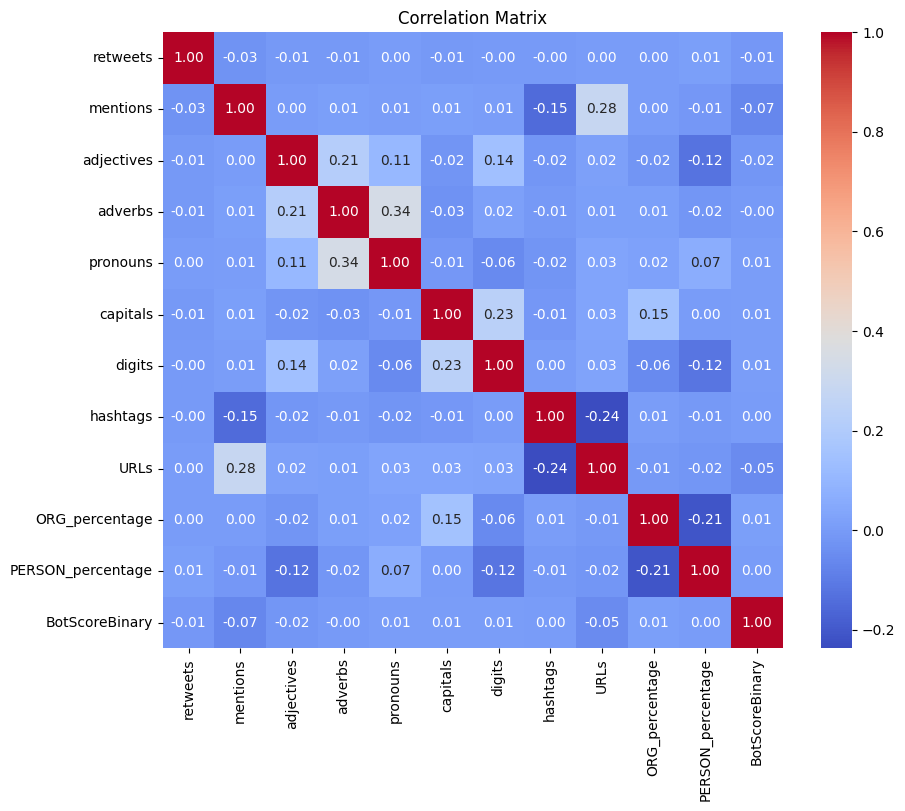

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume x_numeric is the DataFrame of your numeric features and y is the target variable
x_numeric = pd.DataFrame(x_numeric_scaled, columns=numeric_features)

# Combine features with the target variable
data_combined = pd.concat([x_numeric, y], axis=1)

# Correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [67]:
# Split data into training and testing sets
x_train_text, x_test_text, x_train_numeric, x_test_numeric, y_train, y_test = train_test_split(
    x_text, x_numeric_scaled, y, test_size=0.2, random_state=42)

In [68]:
# Address class imbalance
smote = SMOTE(random_state=42)
x_train_text_resampled, y_train_resampled = smote.fit_resample(x_train_text, y_train)
x_train_numeric_resampled, y_train_resampled = smote.fit_resample(x_train_numeric, y_train)

In [69]:
# Define RNN model architecture
embedding_dim = 50  # Dimension of word embeddings

In [70]:
# Text input branch
text_input = Input(shape=(max_sequence_length,), name='text_input')
embedding_layer = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_input)
lstm_layer = LSTM(30, kernel_regularizer=l2(0.01))(embedding_layer)
dropout_text = Dropout(0.5)(lstm_layer)

In [71]:
# Numeric input branch
numeric_input = Input(shape=(len(numeric_features),), name='numeric_input')
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(numeric_input)
dropout_numeric = Dropout(0.5)(dense_layer)

In [72]:
# Concatenate both branches
concatenated = concatenate([dropout_text, dropout_numeric])

In [73]:
# Output layer
output = Dense(1, activation='sigmoid', name='output')(concatenated)

In [74]:
from tensorflow.keras.optimizers import AdamW


In [75]:
# Define optimizer with a specific learning rate
optimizer  = AdamW(learning_rate=0.001)


In [76]:
# Create model
model = Model(inputs=[text_input, numeric_input], outputs=output)

In [77]:
# Compile model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 100)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 100, 50)              50000     ['text_input[0][0]']          
                                                                                                  
 numeric_input (InputLayer)  [(None, 11)]                 0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 30)                   9720      ['embedding_1[0][0]']         
                                                                                            

In [78]:

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [79]:
# Train model
history = model.fit(
    {'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled},
    y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_data=({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100
500/500 [==============================] - 22s 39ms/step - loss: 0.7952 - accuracy: 0.6221 - val_loss: 0.6810 - val_accuracy: 0.6572
Epoch 2/100
500/500 [==============================] - 19s 37ms/step - loss: 0.5890 - accuracy: 0.7060 - val_loss: 0.6354 - val_accuracy: 0.6989
Epoch 3/100
500/500 [==============================] - 19s 38ms/step - loss: 0.5640 - accuracy: 0.7210 - val_loss: 0.5968 - val_accuracy: 0.7197
Epoch 4/100
500/500 [==============================] - 18s 37ms/step - loss: 0.5439 - accuracy: 0.7370 - val_loss: 0.6466 - val_accuracy: 0.6786
Epoch 5/100
500/500 [==============================] - 19s 38ms/step - loss: 0.5286 - accuracy: 0.7456 - val_loss: 0.6755 - val_accuracy: 0.6704
Epoch 6/100
500/500 [==============================] - 18s 35ms/step - loss: 0.5194 - accuracy: 0.7549 - val_loss: 0.5660 - val_accuracy: 0.7529
Epoch 7/100
500/500 [==============================] - 20s 40ms/step - loss: 0.5040 - accuracy: 0.7659 - val_loss: 0.6221 - val_ac

In [80]:
# Evaluate model on train set
train_loss, train_accuracy = model.evaluate({'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled}, y_train_resampled)
print(f'Train accuracy: {train_accuracy}')

999/999 [==============================] - 8s 8ms/step - loss: 0.5116 - accuracy: 0.7631
Train accuracy: 0.7631463408470154


In [81]:

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate({'text_input': x_test_text, 'numeric_input': x_test_numeric}, y_test)
print(f'Test accuracy: {test_accuracy}')

153/153 [==============================] - 1s 8ms/step - loss: 0.5660 - accuracy: 0.7529
Test accuracy: 0.7529267072677612


In [82]:

import matplotlib.pyplot as plt


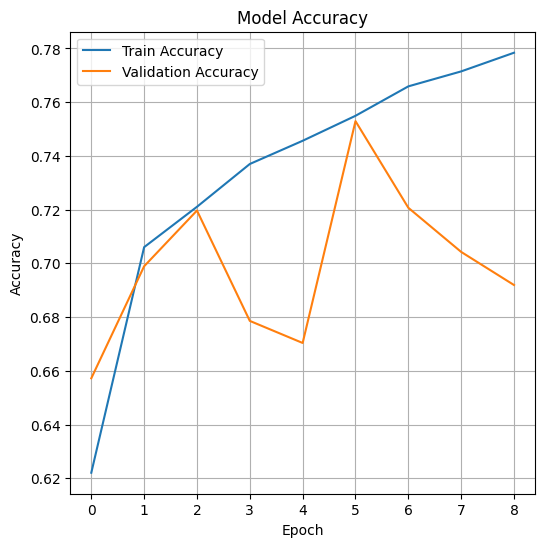

In [83]:
# Plot training & validation accuracy values
plt.figure(figsize=(6, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [84]:
# Predict on test set
y_pred = model.predict({'text_input': x_test_text, 'numeric_input': x_test_numeric})
y_pred_classes = (y_pred > 0.5).astype(int)

153/153 [==============================] - 2s 12ms/step


In [85]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print(cm)

[[3444  582]
 [ 621  222]]


In [86]:
import seaborn as sns


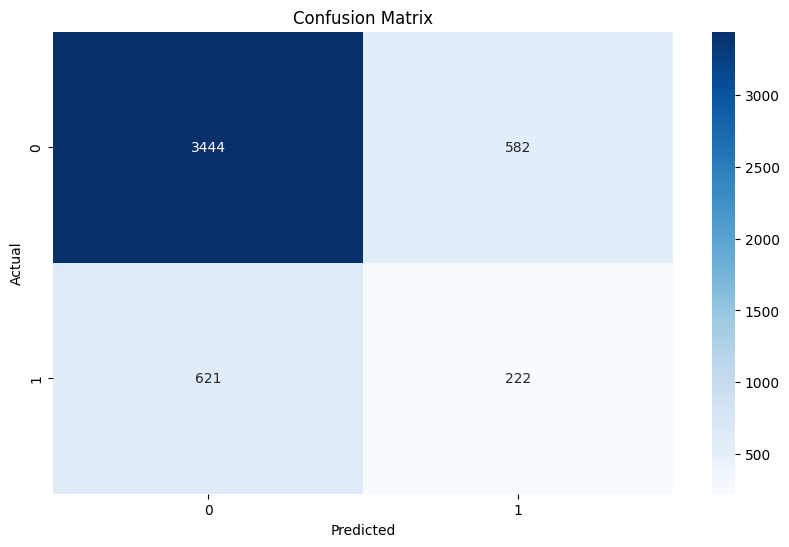

In [87]:
# Plot confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

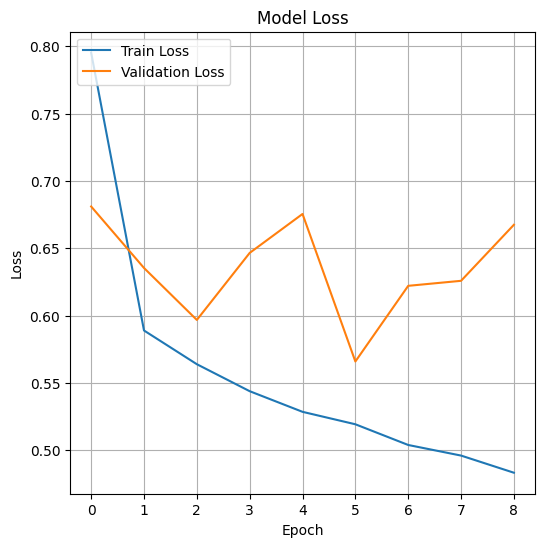

In [88]:
# Plot training & validation loss values
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [89]:
model.save('twitter_bot_detection_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


preprocessing srilankan data for retraining

In [90]:
custom_data  = pd.read_csv('/content/drive/MyDrive/Dataset/updated_tweets.csv')
custom_data .head()

,date,text,link,likes,retweets,comments,user_name,user_username,user_avatar,label,...,word_count,adjectives,adverbs,pronouns,capitals,digits,hashtags,URLs,ORG_percentage,PERSON_percentage
0,"Jan 9, 2021 · 12:41 PM UTC",ඔබට ඔබගේ #hashtag #retweet කරගැනීමට අවශ්‍ය නම්...,https://twitter.com/SLRTBot/status/13478862284...,97,34,21,SL RT Bot 🇱🇰🤖,@SLRTBot,https://pbs.twimg.com/profile_images/134775335...,1,...,9,1,0,0,3,0,3,0,0.0,0.0
1,"Jun 13, 2023 · 3:54 PM UTC",she made breakfast! anyone want some? #tasty...,https://twitter.com/CutestGraham/status/166864...,10,2,2,𝐴𝑠ℎ𝑙𝑒𝑦 𝐺𝑟𝑎ℎ𝑎𝑚,@CutestGraham,https://pbs.twimg.com/profile_images/164524557...,1,...,7,0,0,1,0,0,1,0,0.0,0.0
2,"Jun 13, 2023 · 4:02 PM UTC",It's #TastyTuesday and this chocolate hazelnut...,https://twitter.com/FoodlinkNY/status/16686500...,2,1,0,Foodlink,@FoodlinkNY,https://pbs.twimg.com/profile_images/133896538...,1,...,29,4,1,1,10,0,4,0,20.0,20.0
3,"Jun 13, 2023 · 4:02 PM UTC",This #TastyTuesday just got tastier! Enjoy a m...,https://twitter.com/SnarfHappens/status/166865...,2,1,0,Snarf's Sandwiches,@SnarfHappens,https://pbs.twimg.com/profile_images/131679554...,1,...,20,3,1,0,8,0,2,0,50.0,50.0
4,"Jun 13, 2023 · 5:43 PM UTC",Change your lunch plans and come have cold dri...,https://twitter.com/Hotshots_Bar/status/166867...,0,1,0,Hotshots Sports Bar and Grill,@Hotshots_Bar,https://pbs.twimg.com/profile_images/170216292...,1,...,16,0,0,1,6,0,2,0,20.0,40.0


In [91]:
column_names = custom_data .columns
print(column_names)

Index(['date', 'text', 'link', 'likes', 'retweets', 'comments', 'user_name',
       'user_username', 'user_avatar', 'label', 'mentions', 'word_count',
       'adjectives', 'adverbs', 'pronouns', 'capitals', 'digits', 'hashtags',
       'URLs', 'ORG_percentage', 'PERSON_percentage'],
      dtype='object')


In [92]:
# Ensure 'text' column contains strings
custom_data['text'] = custom_data['text'].astype(str)

# Replace NaN or missing values with empty strings
custom_data['text'] = custom_data['text'].fillna('')


In [93]:
# Preprocess text data
max_words = 1000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(custom_data['text'])
sequences = tokenizer.texts_to_sequences(custom_data['text'])
x_text = pad_sequences(sequences, maxlen=max_sequence_length)

In [94]:
numeric_features = [
    'retweets',
    'mentions',
    'adjectives',
    'adverbs',
    'pronouns',
    'capitals',
    'digits',
    'hashtags',
    'URLs',
    'ORG_percentage',
    'PERSON_percentage'
]

In [95]:
# Extract numeric features from the custom dataset
custom_numeric_data = custom_data[numeric_features].values

# Scale the numeric features using the scaler that was fitted on the original dataset
custom_numeric_scaled = scaler.transform(custom_numeric_data)

# Tokenize and pad the text data from the custom dataset
sequences = tokenizer.texts_to_sequences(custom_data['text'])
custom_text_data = pad_sequences(sequences, maxlen=max_sequence_length)

In [96]:
x_train_text1, x_test_text1, x_train_numeric1, x_test_numeric1, y_train1, y_test1 = train_test_split(
    custom_text_data, custom_numeric_scaled, custom_data['label'], test_size=0.2, random_state=42)


In [97]:
smote = SMOTE(random_state=42)
x_train_text_resampled, y_train_resampled = smote.fit_resample(x_train_text1, y_train1)
x_train_numeric_resampled, y_train_resampled = smote.fit_resample(x_train_numeric1, y_train1)


In [98]:
from tensorflow.keras.models import load_model

model = load_model('/content/twitter_bot_detection_model.h5')


In [99]:
# Train the model with the resampled data
history = model.fit(
    {'text_input': x_train_text_resampled, 'numeric_input': x_train_numeric_resampled},
    y_train_resampled,
    epochs=100,
    batch_size=64,
    validation_data=({'text_input': x_test_text1, 'numeric_input': x_test_numeric1}, y_test1),
    callbacks=[early_stopping]
)


Epoch 1/100
6/6 [==============================] - 2s 130ms/step - loss: 0.9482 - accuracy: 0.5895 - val_loss: 0.6319 - val_accuracy: 0.7000
Epoch 2/100
6/6 [==============================] - 0s 40ms/step - loss: 0.7588 - accuracy: 0.7346 - val_loss: 0.3354 - val_accuracy: 0.8000
Epoch 3/100
6/6 [==============================] - 0s 43ms/step - loss: 0.6545 - accuracy: 0.7994 - val_loss: 0.6437 - val_accuracy: 0.8333
Epoch 4/100
6/6 [==============================] - 0s 40ms/step - loss: 0.6184 - accuracy: 0.8642 - val_loss: 0.2996 - val_accuracy: 0.8667
Epoch 5/100
6/6 [==============================] - 0s 44ms/step - loss: 0.4649 - accuracy: 0.8333 - val_loss: 0.4383 - val_accuracy: 0.8167
Epoch 6/100
6/6 [==============================] - 0s 44ms/step - loss: 0.3694 - accuracy: 0.8704 - val_loss: 0.5407 - val_accuracy: 0.7833
Epoch 7/100
6/6 [==============================] - 0s 40ms/step - loss: 0.3631 - accuracy: 0.8488 - val_loss: 0.4141 - val_accuracy: 0.8167


In [112]:
# Evaluate model on train set
train_loss, train_accuracy = model.evaluate(
    {'text_input': x_train_text1, 'numeric_input':x_train_numeric1},
    y_train1
)
print(f'Train accuracy: {train_accuracy}')


8/8 [==============================] - 0s 12ms/step - loss: 0.2964 - accuracy: 0.8917
Train accuracy: 0.8916666507720947


In [107]:
# Test accuracy for retraining

test_loss, test_accuracy = model.evaluate({'text_input': x_test_text1, 'numeric_input': x_test_numeric1}, y_test1)
print(f'Test accuracy: {test_accuracy}')


2/2 [==============================] - 0s 17ms/step - loss: 0.2996 - accuracy: 0.8667
Test accuracy: 0.8666666746139526


In [108]:
y_pred = model.predict({'text_input': x_test_text1, 'numeric_input': x_test_numeric1})


2/2 [==============================] - 0s 16ms/step


In [109]:
y_pred_classes = (y_pred > 0.5).astype(int)


In [110]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test1, y_pred_classes)
print(cm)


[[33  5]
 [ 3 19]]


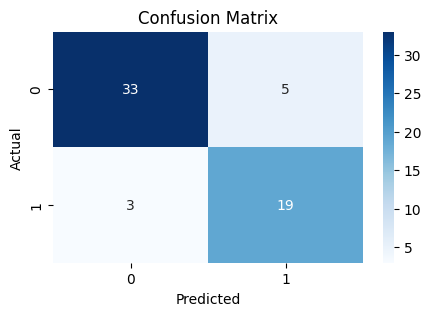

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


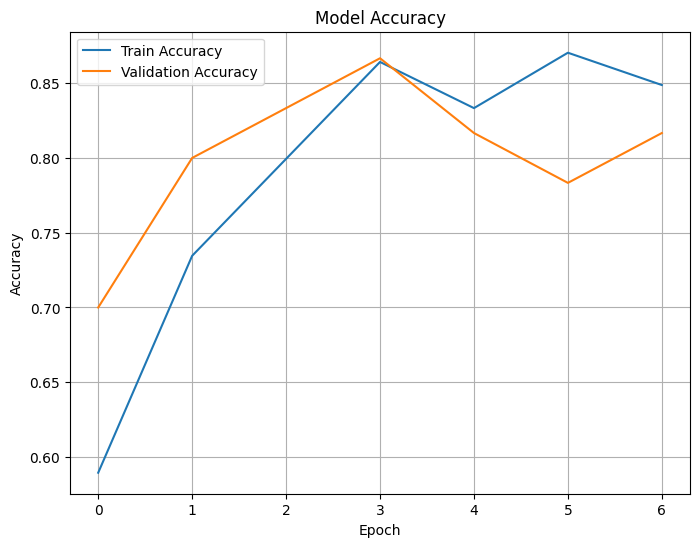

In [116]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


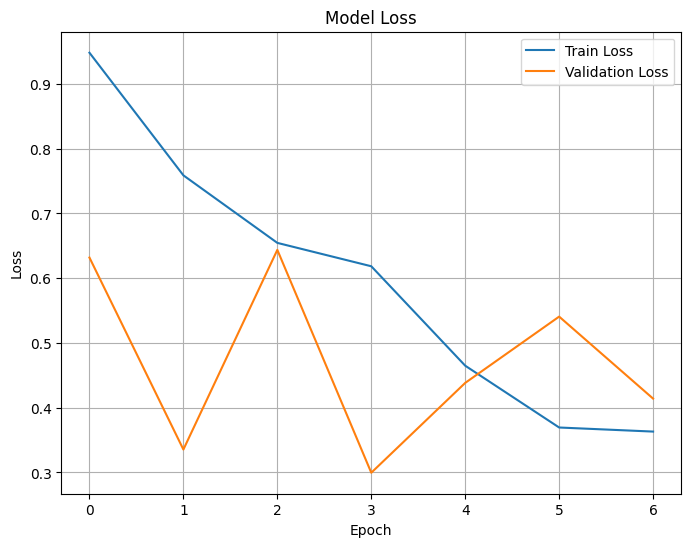

In [115]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
